# TODO:

* test this notebook (copy)
* record videos

# Install Dependencies (run then restart):

In [1]:
!apt update
!apt install -y cmake
!apt-get install -y build-essential autoconf libtool pkg-config
!apt-get install flex bison libbz2-dev
!pip install nle
!pip install minihack
!pip install gym[atari,accept-rom-license]

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:13 http://security.ubuntu.com/ubuntu 

# Global Variables

In [1]:
PATH = '/content/drive/MyDrive/RL_Project/' # path for files
device = "cuda" # GPU
adam = True # use Adam optimiser
policy_file = 'dqn_policy_weights_final.pth' # policy weights file
target_file = 'dqn_target_weights_final.pth' # target weights file
rewards_file = '' # rewards file (determined during runtime)
save_model = False # bool to save model weights
save_rewards = False # bool to save rewards
load_model = False # bool to load model weights

# Libraries

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import nle
from nle import nethack
import minihack
from minihack import RewardManager
from gym import spaces
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch
import random
import time
import pandas as pd

# I'm supressing the gym warnings but you can remove this to see them
import warnings
warnings.filterwarnings("ignore")

# Drive Connect

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Classes

## Replay Buffer

In [4]:
class ReplayBuffer:
    """
    Simple storage for transitions from an environment.
    """

    def __init__(self, size):
        """
        Initialise a buffer of a given size for storing transitions
        :param size: the maximum number of transitions that can be stored
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer. Old transitions will be overwritten if the buffer is full.
        :param state: the agent's initial state
        :param action: the action taken by the agent
        :param reward: the reward the agent received
        :param next_state: the subsequent state
        :param done: whether the episode terminated
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, indices):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones),
        )

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        :param batch_size: the number of transitions to sample
        :return: a mini-batch of sampled transitions
        """
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        return self._encode_sample(indices)

## Model

In [34]:
class DQN(nn.Module):
    """
    A basic implementation of a Deep Q-Network. The architecture is the same as that described in the
    Nature DQN paper.
    """

    def __init__(self, input_size, action_space):
        """
        Initialise the DQN
        :param input_size: size of the input received
        :param action_space: the action space of the environment
        """
        super().__init__()
       
        # self.fc1 = nn.Linear(in_features=input_size, out_features=256)
        # self.fc2 = nn.Linear(in_features=256 , out_features=256)
        # self.fc3 = nn.Linear(in_features=256 , out_features=128)
        # self.fc4 = nn.Linear(in_features=128, out_features=action_space.n)
        self.fc1 = nn.Linear(in_features=input_size, out_features=32)
        self.fc2 = nn.Linear(in_features=32 , out_features=32)
        self.fc3 = nn.Linear(in_features=32 , out_features=16)
        self.fc4 = nn.Linear(in_features=16, out_features=action_space.n)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

## Reward Shaping

In [6]:
class ExploreEvent(minihack.reward_manager.Event):
    def __init__(self, reward: float, repeatable: bool, terminal_required: bool, terminal_sufficient: bool):
        super().__init__(reward, repeatable, terminal_required, terminal_sufficient)

    def check(self, env, previous_observation, action, observation) -> float:
        current = sum(np.count_nonzero(i == 35) for i in observation[1])
        current += sum(np.count_nonzero(i == 60) for i in observation[1])
        prev = sum(np.count_nonzero(i == 35) for i in previous_observation[1])
        prev += sum(np.count_nonzero(i == 60) for i in previous_observation[1])
        if current > prev:
            return self.reward
        else:
            return 0

## Agent

In [32]:
class DQNAgent:
    def __init__(
        self,
        input_size,
        action_space,
        replay_buffer,
        use_double_dqn,
        lr,
        batch_size,
        gamma,
    ):
        """
        Initialise the DQN algorithm using the Adam optimiser
        :param action_space: the action space of the environment
        :param input_size: the size of the input received by the agent
        :param replay_buffer: storage for experience replay
        :param lr: the learning rate for Adam
        :param batch_size: the batch size
        :param gamma: the discount factor
        """

        # Initialise agent's networks, optimiser and replay buffer
        self.lr = lr
        self.replay_buffer = replay_buffer
        self.gamma = gamma
        self.batch_size = batch_size
        self.use_double_dqn = use_double_dqn
        self.target_network = DQN(input_size,action_space).to(device)
        self.policy_network = DQN(input_size,action_space).to(device)
        if adam:
          self.optimiser = Adam(self.policy_network.parameters(),lr=self.lr)
        else:
          self.optimiser = torch.optim.RMSprop(self.policy_network.parameters(), lr=self.lr, momentum=0.95)
        self.policy_path = PATH + policy_file
        self.target_path = PATH + target_file
        if load_model:
          self.load_model_weights()

    def save_model_weights(self):
      """
      saves the current policy and target network weights
      """
      torch.save(self.policy_network.state_dict(), self.policy_path)
      torch.save(self.target_network.state_dict(), self.target_path)

    def load_model_weights(self):
      """
      loads the policy and target network weights if they exist
      """
      try:
        self.policy_network.load_state_dict(torch.load(self.policy_path))
        self.policy_network.eval()
        self.target_network.load_state_dict(torch.load(self.target_path))
        self.target_network.eval()
      except:
        print("Either something went wrong when loading the model weights or they don't exist.")
        

    def optimise_td_loss(self):
        """
        Optimise the TD-error over a single minibatch of transitions
        :return: the loss
        """
        #   Optimise the TD-error over a single minibatch of transitions
        #   Sample the minibatch from the replay-memory
        #   using done (as a float) instead of if statement
        #   return loss

        # get batch from replay buffer and convert info into tensors
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = np.array(states)
        next_states = np.array(next_states)
        tensor_states = torch.from_numpy(states).float().to(device)
        tensor_next_states = torch.from_numpy(next_states).float().to(device)
        tensor_actions = torch.from_numpy(actions).long().to(device)
        tensor_rewards = torch.from_numpy(rewards).float().to(device)
        tensor_dones = torch.from_numpy(dones).float().to(device)

        # don't track gradients
        with torch.no_grad():
            # calculate target
            estimate = None
            if self.use_double_dqn:
                # get next action from the other network
                _, next_action = self.policy_network(tensor_states).max(1)
                # get next q from target network
                estimate = self.target_network(tensor_next_states).gather(1, next_action.unsqueeze(1)).squeeze()
            else:
                # get next q from target network
                estimate = self.target_network(tensor_next_states).max(1)

            target = tensor_rewards + (1 - tensor_dones) * self.gamma * estimate[0]

        # backpropagation
        new_estimate = self.policy_network(tensor_states).gather(1, tensor_actions.unsqueeze(1)).squeeze()
        loss = F.smooth_l1_loss(new_estimate, target)
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        del states
        del next_states

        return loss.item()


    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def act(self, state):
        """
        Select an action greedily from the Q-network given the state
        :param state: the current state
        :return: the action to take
        """
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # making sure gradients aren't saved for the following calculations
        with torch.no_grad():
            # get action-state values using the foward pass of the network
            qs = self.policy_network(state)
            # get max action
            _, action = qs.max(1)
            # return action from tensor object
            return action.item()

# Run Functions

## Training

In [ ]:
def create_and_train_agent(
    hyper_params, # model hyperparameters
    limited_actions=False, # play with limited actions bool
    reward_shaping=False, # play with reward shaping bool
    random_agent=False, # use random agent
    stop_early=True, # stop after 100 episodes bool
    is_run=True # determines what to print
    ):
  
    # recording stuff
    dir = None
    if hyper_params["save_recording"]:
      dir = hyper_params["tyrec-file-dir"]

    # reward shaping
    reward_manager = RewardManager()
    reward_manager.add_eat_event("apple", reward=1)
    reward_manager.add_coordinate_event((11,72), reward=1, terminal_required = False) # first door at end of maze
    reward_manager.add_kill_event("minotaur", reward=1, terminal_required=False)
    strings = list()
    strings.append("The door opens.")
    reward_manager.add_message_event(strings, reward=1, terminal_required=True)
    strings = list()
    strings.append("It's solid stone.")
    reward_manager.add_message_event("It's solid stone.", reward=-0.01, terminal_required=False, repeatable=True)
    reward_manager.add_event(ExploreEvent(0.5, True, True, False))
    strings = list()
    strings.append("What a strange direction!  Never mind.")
    reward_manager.add_message_event("What a strange direction!  Never mind.", reward=-0.01, terminal_required=False, repeatable=True)
    reward_manager.add_event(ExploreEvent(0.5, True, True, False))
    strings = list()
    strings.append("What a strange direction! Never mind.")
    reward_manager.add_message_event("What a strange direction! Never mind.", reward=-0.01, terminal_required=False, repeatable=True)
    reward_manager.add_event(ExploreEvent(0.5, True, True, False))


    # the actions allowed by the agent (https://minihack.readthedocs.io/en/latest/getting-started/action_spaces.html)
    MOVE_ACTIONS = tuple(nethack.CompassDirection)
    NAVIGATE_ACTIONS = MOVE_ACTIONS + (
        nethack.Command.OPEN,
        nethack.Command.PICKUP, 
        nethack.Command.WEAR,   
        nethack.Command.WIELD,  
        nethack.Command.QUAFF,
        nethack.Command.INVOKE,
        nethack.Command.ZAP,
        nethack.Command.SWAP,
    )

    # make environment
    if limited_actions:
      if reward_shaping:
        env = gym.make(
            hyper_params["env"],
            observation_keys=("glyphs_crop", "chars", "colors", "pixel", "message", "blstats", "pixel_crop"),
            actions=NAVIGATE_ACTIONS,
            reward_lose=-1,
            reward_win=1,
            reward_manager=reward_manager,
            savedir=dir
        )
      else:
        env = gym.make(
            hyper_params["env"],
            observation_keys=("glyphs_crop", "chars", "colors", "pixel", "message", "blstats", "pixel_crop"),
            actions=NAVIGATE_ACTIONS,
            reward_lose=-1,
            reward_win=1,
            savedir=dir
        )
    else:
      if reward_shaping:
        env = gym.make(
            hyper_params["env"],
            observation_keys=("glyphs_crop", "chars", "colors", "pixel", "message", "blstats", "pixel_crop"),
            reward_lose=-1,
            reward_win=1,
            reward_manager=reward_manager,
            savedir=dir
        )
      else:
        env = gym.make(
            hyper_params["env"],
            observation_keys=("glyphs_crop", "chars", "colors", "pixel", "message", "blstats", "pixel_crop"),
            savedir=dir
        )

    # seeds
    env.seed(hyper_params["seed"])
    np.random.seed(hyper_params["seed"])
    random.seed(hyper_params["seed"])


    # Create dqn agent
    replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])
    agent = DQNAgent(
          81, # 9*9 (glyphs are 21 by 79 but glyphs_crop centered 9x9 around the agent)
          env.action_space,
          replay_buffer,
          use_double_dqn=hyper_params["use-double-dqn"],
          lr=hyper_params["learning-rate"],
          batch_size= hyper_params["batch-size"],
          gamma=hyper_params["discount-factor"],
        )
    
    # global vars
    eps_timesteps = hyper_params["eps-fraction"] * float(hyper_params["num-steps"])
    episode_rewards = [0.0]
    
    state = env.reset()['glyphs_crop'].flatten()

    for t in range(hyper_params["num-steps"]):
        fraction = min(1.0, float(t) / eps_timesteps)
        eps_threshold = hyper_params["eps-start"] + fraction * (
            hyper_params["eps-end"] - hyper_params["eps-start"]
        )
        sample = random.random()
        if sample < eps_threshold or random_agent:
            action = env.action_space.sample()
        else:
            action = agent.act(state)

        #take next step
        next_state_temp, reward, done, _ = env.step(action)
        next_state = next_state_temp['glyphs_crop'].flatten()
        agent.replay_buffer.add(state, action, reward, next_state, float(done))
        state = next_state
        episode_rewards[-1] += reward

        if done:
            state = env.reset()['glyphs_crop'].flatten()
            episode_rewards.append(0.0)

        if (
            t > hyper_params["learning-starts"]
            and t % hyper_params["learning-freq"] == 0
            and not random_agent
        ):
            agent.optimise_td_loss()

        if (
            t > hyper_params["learning-starts"]
            and t % hyper_params["target-update-freq"] == 0
            and not random_agent
        ):
            agent.update_target_network()

        num_episodes = len(episode_rewards)

        if done and not is_run:
          print("Episode:", str(num_episodes))

        if (
            done
            and hyper_params["print-freq"] is not None
            and len(episode_rewards) % hyper_params["print-freq"] == 0
        ):
            mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
            print("********************************************************")
            print("steps: {}".format(t))
            print("episodes: {}".format(num_episodes))
            print("mean 100 episode reward: {}".format(mean_100ep_reward))
            print("% time spent exploring: {}".format(int(100 * eps_threshold)))
            print("********************************************************")
            if save_rewards:
              np.savetxt(PATH + rewards_file, episode_rewards)
            if save_model:
              agent.save_model_weights()

        if stop_early and num_episodes==100:
          return episode_rewards[:-1]

## Testing

In [ ]:
def create_and_test_agent(
    hyper_params, # model hyperparameters
    limited_actions=False, # play with limited actions bool
    reward_shaping=False, # play with reward shaping bool
    random_agent=False, # use random agent
    stop_early=True, # stop after 100 episodes bool
    is_run=True # determines what to print
    ):
  
    # recording stuff
    dir = None
    if hyper_params["save_recording"]:
      dir = hyper_params["tyrec-file-dir"]

    # reward shaping
    reward_manager = RewardManager()
    reward_manager.add_eat_event("apple", reward=1)
    reward_manager.add_coordinate_event((11,27), reward=1, terminal_required = False) # first door at end of maze
    reward_manager.add_kill_event("minotaur", reward=1, terminal_required=False)
    strings = list()
    strings.append("The door opens.")
    reward_manager.add_message_event(strings, reward=1, terminal_required=True)
    strings = list()
    strings.append("It's solid stone.")
    reward_manager.add_message_event("It's solid stone.", reward=-0.01, terminal_required=False, repeatable=True)
    reward_manager.add_event(ExploreEvent(0.5, True, True, False))
    strings = list()
    strings.append("What a strange direction!  Never mind.")
    reward_manager.add_message_event("What a strange direction!  Never mind.", reward=-0.01, terminal_required=False, repeatable=True)
    reward_manager.add_event(ExploreEvent(0.5, True, True, False))
    strings = list()
    strings.append("What a strange direction! Never mind.")
    reward_manager.add_message_event("What a strange direction! Never mind.", reward=-0.01, terminal_required=False, repeatable=True)
    reward_manager.add_event(ExploreEvent(0.5, True, True, False))


    # the actions allowed by the agent (https://minihack.readthedocs.io/en/latest/getting-started/action_spaces.html)
    MOVE_ACTIONS = tuple(nethack.CompassDirection)
    NAVIGATE_ACTIONS = MOVE_ACTIONS + (
        nethack.Command.OPEN,
        nethack.Command.PICKUP, 
        nethack.Command.WEAR,   
        nethack.Command.WIELD,  
        nethack.Command.QUAFF,
        nethack.Command.INVOKE,
        nethack.Command.ZAP,
        nethack.Command.SWAP,
    )

    # make environment
    if limited_actions:
      if reward_shaping:
        env = gym.make(
            hyper_params["env"],
            observation_keys=("glyphs_crop", "chars", "colors", "pixel", "message", "blstats", "pixel_crop"),
            actions=NAVIGATE_ACTIONS,
            reward_lose=-1,
            reward_win=1,
            reward_manager=reward_manager,
            savedir=dir
        )
      else:
        env = gym.make(
            hyper_params["env"],
            observation_keys=("glyphs_crop", "chars", "colors", "pixel", "message", "blstats", "pixel_crop"),
            actions=NAVIGATE_ACTIONS,
            reward_lose=-1,
            reward_win=1,
            savedir=dir
        )
    else:
      if reward_shaping:
        env = gym.make(
            hyper_params["env"],
            observation_keys=("glyphs_crop", "chars", "colors", "pixel", "message", "blstats", "pixel_crop"),
            reward_lose=-1,
            reward_win=1,
            reward_manager=reward_manager,
            savedir=dir
        )
      else:
        env = gym.make(
            hyper_params["env"],
            observation_keys=("glyphs_crop", "chars", "colors", "pixel", "message", "blstats", "pixel_crop"),
            savedir=dir
        )

    # seeds
    env.seed(hyper_params["seed"])
    np.random.seed(hyper_params["seed"])
    random.seed(hyper_params["seed"])


    # Create dqn agent
    replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])
    agent = DQNAgent(
          81, # 9*9 (glyphs are 21 by 79 but glyphs_crop centered 9x9 around the agent)
          env.action_space,
          replay_buffer,
          use_double_dqn=hyper_params["use-double-dqn"],
          lr=hyper_params["learning-rate"],
          batch_size= hyper_params["batch-size"],
          gamma=hyper_params["discount-factor"],
        )
    
    # global vars
    eps_timesteps = hyper_params["eps-fraction"] * float(hyper_params["num-steps"])
    episode_rewards = [0.0]
    
    state = env.reset()['glyphs_crop'].flatten()

    for t in range(hyper_params["num-steps"]):
        #take next step
        action = agent.act(state)
        next_state_temp, reward, done, _ = env.step(action)
        next_state = next_state_temp['glyphs_crop'].flatten()
        # agent.replay_buffer.add(state, action, reward, next_state, float(done))
        state = next_state
        episode_rewards[-1] += reward

        if done:
            state = env.reset()['glyphs_crop'].flatten()
            episode_rewards.append(0.0)


        num_episodes = len(episode_rewards)

        if (
            done
        ):
            print("********************************************************")
            print("steps: {}".format(t))
            print("episode: {}".format(num_episodes))
            print("episode reward: {}".format(episode_rewards[-2]))
            print("********************************************************")
            if save_rewards:
              np.savetxt(PATH + rewards_file, episode_rewards)
            if save_model:
              agent.save_model_weights()

        if stop_early and num_episodes==100:
          return episode_rewards[:-1]

## Subtask run function

In [ ]:
def run_sub_task(hyper_params):
    global save_model, save_rewards, load_model
    save_model = False
    save_rewards = False
    load_model = False
    total_runs = 10.0
    total_episodes = 100
    print("environment:", hyper_params["env"])
    print("################# Start #################")
    random_agent_rewards_sum = [0 for i in range(total_episodes)]
    for i in range(int(total_runs)):
      if i%2==0:
        print("run "+str(i)+" random agent")
      rewards = create_and_train_agent(hyper_params, random_agent=True)
      random_agent_rewards_sum = [(x + y) for (x, y) in zip(rewards,random_agent_rewards_sum)]
    average_random_agent_rewards = [x/total_runs for x in random_agent_rewards_sum]
    print("################# Random done #################")
    normal_DQN_agent_rewards_sum = [0 for i in range(total_episodes)]
    for i in range(int(total_runs)):
      if i%2==0:
        print("run "+str(i)+" DQN agent")
      rewards = create_and_train_agent(hyper_params)
      normal_DQN_agent_rewards_sum = [(x + y) for (x, y) in zip(rewards,normal_DQN_agent_rewards_sum)]
    average_normal_DQN_agent_rewards = [x/total_runs for x in normal_DQN_agent_rewards_sum]
    print("################# DQN done #################")
    limited_actions_DQN_agent_rewards_sum = [0 for i in range(total_episodes)]
    for i in range(int(total_runs)):
      if i%2==0:
        print("run "+str(i)+" DQN agent variant")
      rewards = create_and_train_agent(hyper_params, limited_actions=True)
      limited_actions_DQN_agent_rewards_sum = [(x + y) for (x, y) in zip(rewards,limited_actions_DQN_agent_rewards_sum)]
    average_limited_actions_DQN_agent_rewards = [x/total_runs for x in limited_actions_DQN_agent_rewards_sum]
    print("################# Limited DQN done #################")

    fig, ax = plt.subplots()
    ax.set_xlabel('Episode no.')
    ax.set_ylabel('Reward')
    ax.set_title('Average rewards per episode on ' + hyper_params["env"])
    x = [i for i in range(len(average_random_agent_rewards))]
    ax.plot(x, average_random_agent_rewards, color = 'green', label = 'random agent')
    ax.plot(x, average_normal_DQN_agent_rewards, color = 'red', label = 'DQN agent')
    ax.plot(x, average_limited_actions_DQN_agent_rewards, color = 'blue', label = 'DQN agent with limited actions')
    plt.legend()
    plt.show()

## Main task run function

In [ ]:
def run_main_task(hyper_params):
    global adam, policy_file, target_file, rewards_file, save_model, save_rewards, load_model
    adam = True # use Adam optimiser
    policy_file = 'dqn_policy_weights_final.pth' # policy weights file
    target_file = 'dqn_target_weights_final.pth' # target weights file
    rewards_file = 'rewards.csv' # rewards file
    save_model = False # bool to save model weights
    save_rewards = False # bool to save rewards
    load_model = False # bool to load model weights
    total_runs = 1.0
    total_episodes = 100
    print("environment:", hyper_params["env"])
    print("reward shaping:", hyper_params["reward_shaping"])
    print("################# Start #################")
    random_agent_rewards_sum = [0 for i in range(total_episodes)]
    for i in range(int(total_runs)):
      print("run "+str(i)+" random agent:")
      rewards = create_and_train_agent(hyper_params, random_agent=True, reward_shaping=hyper_params["reward_shaping"])
      random_agent_rewards_sum = [(x + y) for (x, y) in zip(rewards,random_agent_rewards_sum)]
    average_random_agent_rewards = [x/total_runs for x in random_agent_rewards_sum]
    print("################# Random done #################")
    normal_DQN_agent_rewards_sum = [0 for i in range(total_episodes)]
    for i in range(int(total_runs)):
      print("run "+str(i)+" DQN agent:")
      rewards = create_and_train_agent(hyper_params, reward_shaping=hyper_params["reward_shaping"])
      normal_DQN_agent_rewards_sum = [(x + y) for (x, y) in zip(rewards,normal_DQN_agent_rewards_sum)]
    average_normal_DQN_agent_rewards = [x/total_runs for x in normal_DQN_agent_rewards_sum]
    print("################# DQN done #################")
    limited_actions_DQN_agent_rewards_sum = [0 for i in range(total_episodes)]
    for i in range(int(total_runs)):
      print("run "+str(i)+" DQN agent variant:")
      rewards = create_and_train_agent(hyper_params, limited_actions=True, reward_shaping=hyper_params["reward_shaping"])
      limited_actions_DQN_agent_rewards_sum = [(x + y) for (x, y) in zip(rewards,limited_actions_DQN_agent_rewards_sum)]
    average_limited_actions_DQN_agent_rewards = [x/total_runs for x in limited_actions_DQN_agent_rewards_sum]
    print("################# Limited DQN done #################")

    fig, ax = plt.subplots()
    ax.set_xlabel('Episode no.')
    ax.set_ylabel('Reward')
    if(hyper_params["reward_shaping"]):
      ax.set_title('Average rewards per episode on ' + hyper_params["env"] + ' with reward shaping')
    else:
      ax.set_title('Average rewards per episode on ' + hyper_params["env"])
    x = [i for i in range(len(average_random_agent_rewards))]
    ax.plot(x, average_random_agent_rewards, color = 'green', label = 'random agent')
    ax.plot(x, average_normal_DQN_agent_rewards, color = 'red', label = 'DQN agent')
    ax.plot(x, average_limited_actions_DQN_agent_rewards, color = 'blue', label = 'DQN agent with limited actions')
    plt.legend()
    plt.show()

## Optimisers run

In [ ]:
def run_main_task_optimiser(hyper_params):
    global adam, policy_file, target_file, rewards_file, save_model, save_rewards, load_model
    adam = True # use Adam optimiser
    policy_file = '' # policy weights file
    target_file = '' # target weights file
    rewards_file = '' # rewards file
    save_model = False # bool to save model weights
    save_rewards = False # bool to save rewards
    load_model = False # bool to load model weights
    total_runs = 10.0
    total_episodes = 100
    print("environment:", hyper_params["env"])
    print("################# Start #################")
    normal_DQN_agent_rewards_sum = [0 for i in range(total_episodes)]
    for i in range(int(total_runs)):
      print("run "+str(i)+" DQN agent adam:")
      rewards = create_and_train_agent(hyper_params, limited_actions=True, reward_shaping=hyper_params["reward_shaping"])
      normal_DQN_agent_rewards_sum = [(x + y) for (x, y) in zip(rewards,normal_DQN_agent_rewards_sum)]
    average_normal_DQN_agent_rewards = [x/total_runs for x in normal_DQN_agent_rewards_sum]
    print("################# done #################")
    adam = False
    limited_actions_DQN_agent_rewards_sum = [0 for i in range(total_episodes)]
    for i in range(int(total_runs)):
      print("run "+str(i)+" DQN agent RMSprop:")
      rewards = create_and_train_agent(hyper_params, limited_actions=True, reward_shaping=hyper_params["reward_shaping"])
      limited_actions_DQN_agent_rewards_sum = [(x + y) for (x, y) in zip(rewards,limited_actions_DQN_agent_rewards_sum)]
    average_limited_actions_DQN_agent_rewards = [x/total_runs for x in limited_actions_DQN_agent_rewards_sum]
    print("################# done #################")

    fig, ax = plt.subplots()
    ax.set_xlabel('Episode no.')
    ax.set_ylabel('Reward')
    ax.set_title('Average rewards per episode on ' + hyper_params["env"])
    x = [i for i in range(len(average_normal_DQN_agent_rewards))]
    ax.plot(x, average_normal_DQN_agent_rewards, color = 'red', label = 'Adam')
    ax.plot(x, average_limited_actions_DQN_agent_rewards, color = 'blue', label = 'RMSprop ')
    plt.legend()
    plt.show()

# Run

### Run on MiniHack-LavaCross-Levitate-Potion-Inv-v0 (optimisers):

environment: MiniHack-LavaCross-Levitate-Potion-Inv-v0
################# Start #################
run 0 DQN agent adam:
********************************************************
steps: 1304
episodes: 10
mean 100 episode reward: -96.0
% time spent exploring: 99
********************************************************
********************************************************
steps: 3999
episodes: 20
mean 100 episode reward: -139.7
% time spent exploring: 98
********************************************************
********************************************************
steps: 5699
episodes: 30
mean 100 episode reward: -131.5
% time spent exploring: 98
********************************************************
********************************************************
steps: 8061
episodes: 40
mean 100 episode reward: -138.8
% time spent exploring: 97
********************************************************
********************************************************
steps: 9941
episodes: 50
mean 100

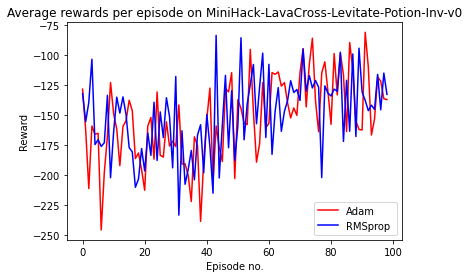

In [ ]:
hyper_params = {
        "seed": 42,  # which seed to use
        "env": "MiniHack-LavaCross-Levitate-Potion-Inv-v0",  # name of the game
        "replay-buffer-size": int(5e3),  # replay buffer size
        "learning-rate": 1e-3,  # learning rate for Adam optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(1e6),  # total number of steps to run the environment for
        "batch-size": 128,  # number of transitions to optimize at the same time
        "learning-starts": 10000,  # number of steps before learning starts
        "learning-freq": 2,  # number of iterations between every optimization step
        "use-double-dqn": True,  # use double deep Q-learning
        "target-update-freq": 1000,  # number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.01,  # e-greedy end threshold
        "eps-fraction": 0.3,  # fraction of num-steps
        "print-freq": 10,
        "tyrec-file-dir": "/content/drive/MyDrive/RL_Project/",
        "save_recording": False,
        "reward_shaping": True,
    }

run_main_task_optimiser(hyper_params)

### Run on MiniHack-Room-5x5-v0:

environment: MiniHack-Room-5x5-v0
################# Start #################
run 0 random agent
run 2 random agent
run 4 random agent
run 6 random agent
run 8 random agent
################# Random done #################
run 0 DQN agent
run 2 DQN agent
run 4 DQN agent
run 6 DQN agent
run 8 DQN agent
################# DQN done #################
run 0 DQN agent variant
run 2 DQN agent variant
run 4 DQN agent variant
run 6 DQN agent variant
run 8 DQN agent variant
################# Limited DQN done #################


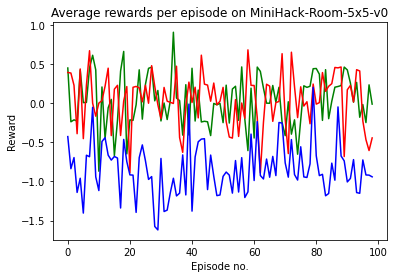

In [ ]:
hyper_params = {
    "seed": 42,  # which seed to use
    "env": "MiniHack-Room-5x5-v0",  # name of the game
    "replay-buffer-size": int(5e3),  # replay buffer size
    "learning-rate": 1e-3,  # learning rate for Adam optimizer
    "discount-factor": 0.99,  # discount factor
    "num-steps": int(1e6),  # total number of steps to run the environment for
    "batch-size": 128,  # number of transitions to optimize at the same time
    "learning-starts": 10000,  # number of steps before learning starts
    "learning-freq": 2,  # number of iterations between every optimization step
    "use-double-dqn": True,  # use double deep Q-learning
    "target-update-freq": 1000,  # number of iterations between every target network update
    "eps-start": 1.0,  # e-greedy start threshold
    "eps-end": 0.01,  # e-greedy end threshold
    "eps-fraction": 0.3,  # fraction of num-steps
    "print-freq": 200,
    "tyrec-file-dir": "/content/drive/MyDrive/RL_Project/",
    "save_recording": False,
}

run_sub_task(hyper_params)

### Run on MiniHack-Room-5x5-v0 (DQN only):

In [ ]:
hyper_params = {
        "seed": 42,  # which seed to use
        "env": "MiniHack-Room-5x5-v0",  # name of the game
        "replay-buffer-size": int(5e3),  # replay buffer size
        "learning-rate": 1e-3,  # learning rate for optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(1e6),  # total number of steps to run the environment for
        "batch-size": 128,  # number of transitions to optimize at the same time
        "learning-starts": 10000,  # number of steps before learning starts
        "learning-freq": 2,  # number of iterations between every optimization step
        "use-double-dqn": True,  # use double deep Q-learning
        "target-update-freq": 1000,  # number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.01,  # e-greedy end threshold
        "eps-fraction": 0.1,  # fraction of num-steps
        "print-freq": 10,
        "tyrec-file-dir": "/content/drive/MyDrive/RL_Project/",
        "save_recording": False,
        "reward_shaping": False,
    }

adam = True # use Adam optimiser
rewards_file = 'room_rewards.csv' # rewards file (determined during runtime)
save_model = False # bool to save model weights
save_rewards = False # bool to save rewards
load_model = False # bool to load model weights

create_and_train_agent(hyper_params, limited_actions=True, stop_early=False, is_run=True)

********************************************************
steps: 837
episodes: 10
mean 100 episode reward: -1.1
% time spent exploring: 99
********************************************************
********************************************************
steps: 1665
episodes: 20
mean 100 episode reward: -0.9
% time spent exploring: 98
********************************************************
********************************************************
steps: 2490
episodes: 30
mean 100 episode reward: -0.8
% time spent exploring: 97
********************************************************
********************************************************
steps: 3321
episodes: 40
mean 100 episode reward: -0.8
% time spent exploring: 96
********************************************************
********************************************************
steps: 4103
episodes: 50
mean 100 episode reward: -0.8
% time spent exploring: 95
********************************************************
*********************

KeyboardInterrupt: ignored

### Run on MiniHack-WoD-Easy-v0:

environment: MiniHack-WoD-Easy-v0
################# Start #################
run 0 random agent
run 2 random agent
run 4 random agent
run 6 random agent
run 8 random agent
################# Random done #################
run 0 DQN agent
run 2 DQN agent
run 4 DQN agent
run 6 DQN agent
run 8 DQN agent
################# DQN done #################
run 0 DQN agent variant
run 2 DQN agent variant
run 4 DQN agent variant
run 6 DQN agent variant
run 8 DQN agent variant
################# Limited DQN done #################


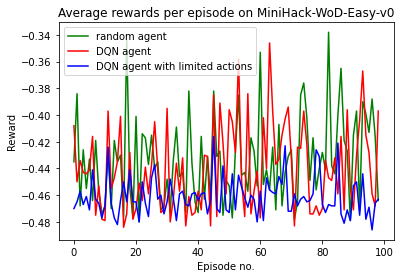

In [ ]:
hyper_params = {
        "seed": 42,  # which seed to use
        "env": "MiniHack-WoD-Easy-v0",  # name of the game
        "replay-buffer-size": int(5e3),  # replay buffer size
        "learning-rate": 1e-3,  # learning rate for Adam optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(1e6),  # total number of steps to run the environment for
        "batch-size": 128,  # number of transitions to optimize at the same time
        "learning-starts": 10000,  # number of steps before learning starts
        "learning-freq": 2,  # number of iterations between every optimization step
        "use-double-dqn": True,  # use double deep Q-learning
        "target-update-freq": 1000,  # number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.01,  # e-greedy end threshold
        "eps-fraction": 0.3,  # fraction of num-steps
        "print-freq": 200,
        "tyrec-file-dir": "/content/drive/MyDrive/RL_Project/",
        "save_recording": False,
    }
    
run_sub_task(hyper_params)

### Run on MiniHack-WoD-Easy-v0 (DQN only):

In [ ]:
hyper_params = {
        "seed": 42,  # which seed to use
        "env": "MiniHack-WoD-Easy-v0",  # name of the game
        "replay-buffer-size": int(5e3),  # replay buffer size
        "learning-rate": 1e-3,  # learning rate for optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(1e6),  # total number of steps to run the environment for
        "batch-size": 128,  # number of transitions to optimize at the same time
        "learning-starts": 10000,  # number of steps before learning starts
        "learning-freq": 2,  # number of iterations between every optimization step
        "use-double-dqn": True,  # use double deep Q-learning
        "target-update-freq": 1000,  # number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.01,  # e-greedy end threshold
        "eps-fraction": 0.1,  # fraction of num-steps
        "print-freq": 10,
        "tyrec-file-dir": "/content/drive/MyDrive/RL_Project/",
        "save_recording": False,
        "reward_shaping": False,
    }

adam = True # use Adam optimiser
rewards_file = 'wand_rewards.csv' # rewards file (determined during runtime)
save_model = False # bool to save model weights
save_rewards = False # bool to save rewards
load_model = False # bool to load model weights

create_and_train_agent(hyper_params, limited_actions=True, stop_early=False, is_run=True)

********************************************************
steps: 449
episodes: 10
mean 100 episode reward: -0.5
% time spent exploring: 99
********************************************************
********************************************************
steps: 924
episodes: 20
mean 100 episode reward: -0.5
% time spent exploring: 99
********************************************************
********************************************************
steps: 1424
episodes: 30
mean 100 episode reward: -0.5
% time spent exploring: 98
********************************************************
********************************************************
steps: 1924
episodes: 40
mean 100 episode reward: -0.5
% time spent exploring: 98
********************************************************
********************************************************
steps: 2401
episodes: 50
mean 100 episode reward: -0.5
% time spent exploring: 97
********************************************************
**********************

KeyboardInterrupt: ignored

### Run on MiniHack-Quest-Hard-v0:

environment: MiniHack-Quest-Hard-v0
reward shaping: True
################# Start #################
run 0 random agent:
********************************************************
steps: 8156
episodes: 10
mean 100 episode reward: -641.2
% time spent exploring: 97
********************************************************
********************************************************
steps: 17891
episodes: 20
mean 100 episode reward: -669.2
% time spent exploring: 94
********************************************************
********************************************************
steps: 27891
episodes: 30
mean 100 episode reward: -684.1
% time spent exploring: 90
********************************************************
********************************************************
steps: 37891
episodes: 40
mean 100 episode reward: -690.5
% time spent exploring: 87
********************************************************
********************************************************
steps: 47275
episodes: 50
mea

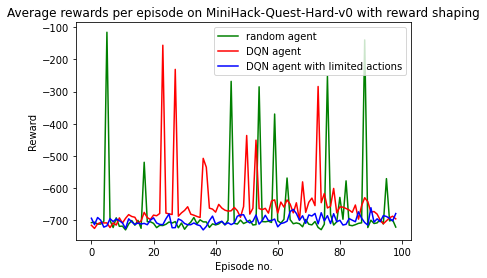

In [ ]:
hyper_params = {
        "seed": 42,  # which seed to use
        "env": "MiniHack-Quest-Hard-v0",  # name of the game
        "replay-buffer-size": int(5e3),  # replay buffer size
        "learning-rate": 1e-3,  # learning rate for Adam optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(1e6),  # total number of steps to run the environment for
        "batch-size": 128,  # number of transitions to optimize at the same time
        "learning-starts": 10000,  # number of steps before learning starts
        "learning-freq": 2,  # number of iterations between every optimization step
        "use-double-dqn": True,  # use double deep Q-learning
        "target-update-freq": 1000,  # number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.01,  # e-greedy end threshold
        "eps-fraction": 0.3,  # fraction of num-steps
        "print-freq": 10,
        "tyrec-file-dir": "/content/drive/MyDrive/RL_Project/",
        "save_recording": False,
        "reward_shaping": True,
    }

run_main_task(hyper_params)

### Record run:

In [ ]:
hyper_params = {
        "seed": 42,  # which seed to use
        "env": "MiniHack-Quest-Hard-v0",  # name of the game
        "replay-buffer-size": int(5e3),  # replay buffer size
        "learning-rate": 1e-3,  # learning rate for optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(1e6),  # total number of steps to run the environment for
        "batch-size": 128,  # number of transitions to optimize at the same time
        "learning-starts": 10000,  # number of steps before learning starts
        "learning-freq": 2,  # number of iterations between every optimization step
        "use-double-dqn": True,  # use double deep Q-learning
        "target-update-freq": 1000,  # number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.2,  # e-greedy end threshold
        "eps-fraction": 0.3,  # fraction of num-steps
        "print-freq": 10,
        "tyrec-file-dir": "/content/drive/MyDrive/RL_Project/recordings/",
        "save_recording": True,
        "reward_shaping": True,
    }

adam = True # use Adam optimiser
policy_file = 'dqn_policy_weights_final_test.pth' # policy weights file
target_file = 'dqn_target_weights_final_test.pth' # target weights file
rewards_file = 'rewards_test.csv' # rewards file (determined during runtime)
save_model = False # bool to save model weights
save_rewards = False # bool to save rewards
load_model = True # bool to load model weights

create_and_train_agent2(hyper_params, limited_actions=True, reward_shaping=True, stop_early=False)

********************************************************
steps: 8999
episodes: 10
mean 100 episode reward: -27.3
% time spent exploring: 97
********************************************************
********************************************************
steps: 18999
episodes: 20
mean 100 episode reward: -25.0
% time spent exploring: 94
********************************************************
********************************************************
steps: 28999
episodes: 30
mean 100 episode reward: -24.1
% time spent exploring: 92
********************************************************
********************************************************
steps: 38999
episodes: 40
mean 100 episode reward: -22.5
% time spent exploring: 89
********************************************************
********************************************************
steps: 48999
episodes: 50
mean 100 episode reward: -22.0
% time spent exploring: 86
********************************************************
***********

KeyboardInterrupt: ignored

100


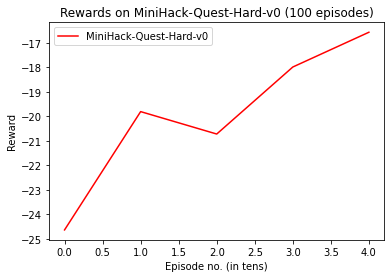

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

end = 100
interval = 20

def get_list_average(array_):
  return sum(array_)/len(array_)

def format_data(array_):
  out = []
  for i in range(interval, end+interval, interval):
    out.append(get_list_average(array_[i-interval:i]))
  return out


rewards = list(pd.read_csv("/content/drive/MyDrive/RL_Project/rewards3.csv").to_numpy().reshape(1,-1)[0])[:end]
print(len(rewards))
rewards = format_data(rewards)

fig, ax = plt.subplots()
ax.set_xlabel('Episode no. (in tens)')
ax.set_ylabel('Reward')
ax.set_title('Rewards on MiniHack-Quest-Hard-v0 (100 episodes)')
x = [i for i in range(len(rewards))]
ax.plot(x, rewards, color = 'red', label = 'MiniHack-Quest-Hard-v0')
# ax.plot(x, wand_rewards, color = 'blue', label = 'MiniHack-WoD-Easy-v0')
plt.legend()
plt.show()

200


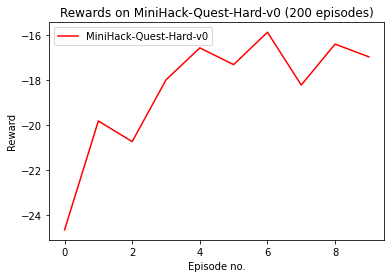

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

end = 200
interval = 20

def get_list_average(array_):
  return sum(array_)/len(array_)

def format_data(array_):
  out = []
  for i in range(interval, end+interval, interval):
    out.append(get_list_average(array_[i-interval:i]))
  return out


rewards = list(pd.read_csv("/content/drive/MyDrive/RL_Project/rewards3.csv").to_numpy().reshape(1,-1)[0])[:end]
print(len(rewards))
rewards = format_data(rewards)

fig, ax = plt.subplots()
ax.set_xlabel('Episode no.')
ax.set_ylabel('Reward')
ax.set_title('Rewards on MiniHack-Quest-Hard-v0 (200 episodes)')
x = [i for i in range(len(rewards))]
ax.plot(x, rewards, color = 'red', label = 'MiniHack-Quest-Hard-v0')
# ax.plot(x, wand_rewards, color = 'blue', label = 'MiniHack-WoD-Easy-v0')
plt.legend()
plt.show()

300


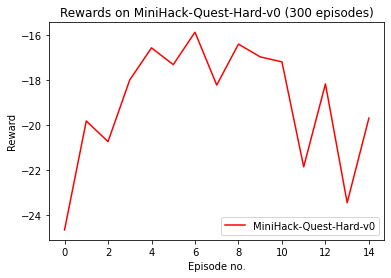

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

end = 300
interval = 20

def get_list_average(array_):
  return sum(array_)/len(array_)

def format_data(array_):
  out = []
  for i in range(interval, end+interval, interval):
    out.append(get_list_average(array_[i-interval:i]))
  return out


rewards = list(pd.read_csv("/content/drive/MyDrive/RL_Project/rewards3.csv").to_numpy().reshape(1,-1)[0])[:end]
print(len(rewards))
rewards = format_data(rewards)

fig, ax = plt.subplots()
ax.set_xlabel('Episode no.')
ax.set_ylabel('Reward')
ax.set_title('Rewards on MiniHack-Quest-Hard-v0 (300 episodes)')
x = [i for i in range(len(rewards))]
ax.plot(x, rewards, color = 'red', label = 'MiniHack-Quest-Hard-v0')
# ax.plot(x, wand_rewards, color = 'blue', label = 'MiniHack-WoD-Easy-v0')
plt.legend()
plt.show()

400


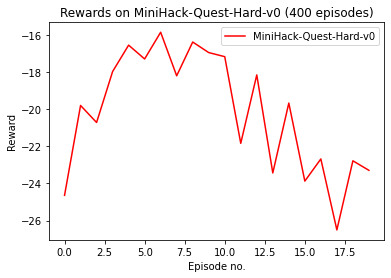

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

end = 400
interval = 20

def get_list_average(array_):
  return sum(array_)/len(array_)

def format_data(array_):
  out = []
  for i in range(interval, end+interval, interval):
    out.append(get_list_average(array_[i-interval:i]))
  return out


rewards = list(pd.read_csv("/content/drive/MyDrive/RL_Project/rewards3.csv").to_numpy().reshape(1,-1)[0])[:end]
print(len(rewards))
rewards = format_data(rewards)

fig, ax = plt.subplots()
ax.set_xlabel('Episode no.')
ax.set_ylabel('Reward')
ax.set_title('Rewards on MiniHack-Quest-Hard-v0 (400 episodes)')
x = [i for i in range(len(rewards))]
ax.plot(x, rewards, color = 'red', label = 'MiniHack-Quest-Hard-v0')
# ax.plot(x, wand_rewards, color = 'blue', label = 'MiniHack-WoD-Easy-v0')
plt.legend()
plt.show()

500


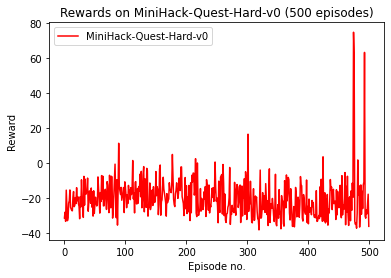

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

end = 500
interval = 1

def get_list_average(array_):
  return sum(array_)/len(array_)

def format_data(array_):
  out = []
  for i in range(interval, end+interval, interval):
    out.append(get_list_average(array_[i-interval:i]))
  return out


rewards = list(pd.read_csv("/content/drive/MyDrive/RL_Project/rewards3.csv").to_numpy().reshape(1,-1)[0])[:end]
print(len(rewards))
rewards = format_data(rewards)

fig, ax = plt.subplots()
ax.set_xlabel('Episode no.')
ax.set_ylabel('Reward')
ax.set_title('Rewards on MiniHack-Quest-Hard-v0 (500 episodes)')
x = [i for i in range(len(rewards))]
ax.plot(x, rewards, color = 'red', label = 'MiniHack-Quest-Hard-v0')
# ax.plot(x, wand_rewards, color = 'blue', label = 'MiniHack-WoD-Easy-v0')
plt.legend()
plt.show()

## Test run

In [ ]:
hyper_params = {
        "seed": 42,  # which seed to use
        "env": "MiniHack-Quest-Hard-v0",  # name of the game
        "replay-buffer-size": int(5e3),  # replay buffer size
        "learning-rate": 1e-3,  # learning rate for optimizer
        "discount-factor": 0.99,  # discount factor
        "num-steps": int(1e6),  # total number of steps to run the environment for
        "batch-size": 128,  # number of transitions to optimize at the same time
        "learning-starts": 10000,  # number of steps before learning starts
        "learning-freq": 2,  # number of iterations between every optimization step
        "use-double-dqn": True,  # use double deep Q-learning
        "target-update-freq": 1000,  # number of iterations between every target network update
        "eps-start": 1.0,  # e-greedy start threshold
        "eps-end": 0.2,  # e-greedy end threshold
        "eps-fraction": 0.3,  # fraction of num-steps
        "print-freq": 10,
        "tyrec-file-dir": "/content/drive/MyDrive/RL_Project/",
        "save_recording": False,
        "reward_shaping": True,
    }

adam = True # use Adam optimiser
policy_file = 'dqn_policy_weights_test.pth' # policy weights file
target_file = 'dqn_target_weights_test.pth' # target weights file
rewards_file = 'rewards_test.csv' # rewards file (determined during runtime)
save_model = True # bool to save model weights
save_rewards = True # bool to save rewards
load_model = True # bool to load model weights

create_and_train_agent(hyper_params, limited_actions=True, reward_shaping=True, stop_early=False)

# Results

In [ ]:
best = max(rewards)
pos = rewards.index(best)
print("best reward on episode:", best)
print("best episode number:", pos)

best reward on episode: 74.93999999999883
best episode number: 474


In [ ]:
worst = min(rewards)
pos = rewards.index(worst)
print("worst reward on episode:", worst)
print("worst episode number:", pos)

worst reward on episode: -38.38999999999937
worst episode number: 319


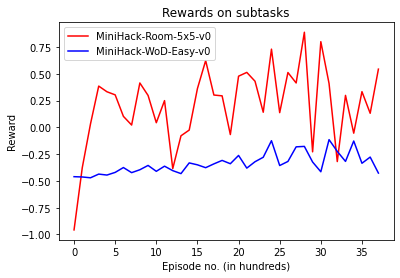

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

end = 3800
interval = 100

def get_list_average(array_):
  return sum(array_)/len(array_)

def format_data(array_):
  out = []
  for i in range(interval, end+interval, interval):
    out.append(get_list_average(array_[i-interval:i]))
  return out


room_rewards = pd.read_csv("/content/drive/MyDrive/RL_Project/room_rewards.csv") 
room_rewards = room_rewards.to_numpy()[:end]
wand_rewards = pd.read_csv("/content/drive/MyDrive/RL_Project/wand_rewards.csv") 
wand_rewards = wand_rewards.to_numpy()[:end]

room_rewards = format_data(room_rewards)
wand_rewards = format_data(wand_rewards)

fig, ax = plt.subplots()
ax.set_xlabel('Episode no. (in hundreds)')
ax.set_ylabel('Reward')
ax.set_title('Rewards on subtasks')
x = [i for i in range(len(room_rewards))]
ax.plot(x, room_rewards, color = 'red', label = 'MiniHack-Room-5x5-v0')
ax.plot(x, wand_rewards, color = 'blue', label = 'MiniHack-WoD-Easy-v0')
plt.legend()
plt.show()